# Art generating GAN

A Generative Adversarial Network for generating new art

# Import required libraries

In [1]:
import os
import pandas as pd

# Keras functions
import tensorflow as tf
import keras
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from matplotlib import pyplot
from IPython.display import clear_output
from keras import backend
from keras.initializers import RandomNormal
from keras.constraints import Constraint

# Numpy functions
import numpy as np
from numpy.random import *
from numpy import *

#Torchvision for fast and easy loading and resizing
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd '/content/drive/MyDrive/Project/GAN_art/GANGogh'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1w8pQAn4l8zm_dSWvO74UiSw2PGeVsyC4/GAN_art/GANGogh


# Load and pre-process the data

In [2]:
dataset_path = "best_artworks/resized/"
saved_path = 'training_data.npy'

WIDTH = 64
HEIGHT = 64
IMG_SIZE = (WIDTH,HEIGHT)
EPOCHS = 250

#Look for saved file to save time loading and processing images between runs
print("Looking for previously saved file...")

if not os.path.isfile(saved_path):

    print("\n File not found, loading new data...\n")
    dataset = []
    transform_ds = transforms.Compose([transforms.Resize(IMG_SIZE),]) #define transformation
    
    image_folder = torchvision.datasets.ImageFolder(root=dataset_path,
                                     transform=transform_ds)

    print('Number of artworks found: ',len(image_folder))
    
    
    print("Converting images, this will take a few minutes")
    for i in range (len(image_folder)):
      try:
        image_array = numpy.array(image_folder[i][0])
        dataset.append(image_array)
        if (i%500 == 0):
            print("Pictures processed: ", i)
      except:
        continue

    print("Saving dataset binary file...")
    dataset = np.array(dataset, dtype=np.float32)
    dataset = (dataset - 127.5) / 127.5 #Normalize to [-1 , 1]
    numpy.save(saved_path, dataset)  #Save processed images as npy file

else:
    print("Data found, loading..")
    dataset = np.load(saved_path) 

print("Dataset length: ", len(dataset))

Looking for previously saved file...
Data found, loading..
Dataset length:  8683


Confirm that the images are the correct shape.

In [3]:
dataset[3].shape

(64, 64, 3)

In [5]:
#Use a TensorFlow Dataset to manage the images for easy shuffling, dividing etc
BATCH_SIZE = 64

training_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(9000).batch(BATCH_SIZE)

# Build the models

The generator will take in a random seed and generate an image from that seed, upsampling as much as needed. Note that increasing resolution will require retuning of the models as well as increase training time by a lot. I found that the generator needs to have quite a lot of capacity in order to keep up with the discriminator at later stages of training.

architecture based on the findings and guidelines proposed in the paper:

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

Further increasing conv layers will lead to mode collapse from what I've tried

In [86]:
# define the standalone generator model
def define_generator(latent_dim):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # define model
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(64*64,input_dim=latent_dim, kernel_initializer=init))
  # model.add(Dense(64*64,activation="relu",input_dim=seed_size))            # 64x64 units
  #model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Reshape((7, 7, 128)))
  model.add(Reshape((16, 16, 16)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  # output 28x28x1
  model.add(Conv2D(3, (7,7), activation='tanh', padding='same', kernel_initializer=init))
  return model

SEED_SIZE = 100
IMAGE_CHANNELS = 3

generator = define_generator(IMAGE_CHANNELS)
print(generator.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 32, 32, 128)       32896     
_________________________________________________________________
batch_normalization_498 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 64, 64, 128)     

In [87]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(64,64,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

critic = define_critic()
print(critic.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_492 (Conv2D)          (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization_500 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_493 (Conv2D)          (None, 16, 16, 64)        65600     
_________________________________________________________________
batch_normalization_501 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)           

In [88]:
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

gan_model = define_gan(generator, critic)
print(gan_model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_21 (Sequential)   (None, 64, 64, 3)         331395    
_________________________________________________________________
sequential_22 (Sequential)   (None, 1)                 85633     
Total params: 417,028
Trainable params: 331,139
Non-trainable params: 85,889
_________________________________________________________________
None


# Define loss functions for the models

**The discriminators loss** is based on its ability to distinguish real images from fakes. It compares its predictions on real images to an array of ones (remember 1 being real) and its predictions on fake images to an array of zeros (0 being fake). The goal is to classify all real images as 1 and all fakes as 0. The total loss is then these two losses added together.

**The generators loss** is a measurement of how good it performed at fooling the discriminator. If the discriminator classifies the fake images as 1, the generator did a good job.


In [89]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100,n_steps=124):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, :])
	# save plot to file
	filename1 = './WGAN/%d/plot/generated_plot_%04d.jpg' %(n_steps,step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = './WGAN/%d/model/model_%04d.h5'%(n_steps,step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist,n_steps):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('./WGAN/{}/plot_line_plot_loss.jpg'.format(n_steps))
	pyplot.close()

# Function for saving the generated images

In [ ]:
'''
GENERATED_ROWS = 7
GENERATED_COLS = 7
MARGIN = 2 # Give the images a little frame

def save_images(cnt, noise):
    #Define the "base" of the saved image as a big black canvas
    image_array = np.full(( 
      MARGIN + (GENERATED_ROWS * (WIDTH + MARGIN)), 
      MARGIN + (GENERATED_COLS * (HEIGHT + MARGIN)), 3), 
      0, dtype=np.uint8)
    
    generated_images =  generator.predict(noise)
    
    image_count = 0
    for row in range(GENERATED_ROWS):
        for col in range(GENERATED_COLS):
            r = row * (WIDTH + 2) + MARGIN
            c = col * (HEIGHT + 2) + MARGIN
            image_array[r:r+WIDTH , c:c+HEIGHT] = generated_images[image_count] * 127.5 + 127.5
            image_count += 1
            
    output_path  = os.path.join("/kaggle/working/generated_wgan/")
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)
'''

# Train the models

The training begins by providing a random seed to the generator, which is then used to generate an image. The discriminator then classifies images from both the fake and real dataset. The loss is calculated separately for each model and the gradients are updated.

Based on the TensorFlow DCGAN tutorial

In [90]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

In [91]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
  # fixed_seed = np.random.normal(0, 1, (GENERATED_ROWS * GENERATED_COLS, SEED_SIZE))
  
  bat_per_epo = int(dataset.shape[0] / n_batch)
  n_steps = int(bat_per_epo * n_epochs)
  half_batch = int(n_batch / 2)
  c1_hist, c2_hist, g_hist = list(), list(), list()
  for i in range(n_steps):
    c1_tmp, c2_tmp = list(), list()
    for _ in range(n_critic):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update critic model weights
      c_loss1 = c_model.train_on_batch(X_real, y_real)
      c1_tmp.append(c_loss1)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update critic model weights
      c_loss2 = c_model.train_on_batch(X_fake, y_fake)
      c2_tmp.append(c_loss2)
    # store critic loss
    c1_hist.append(mean(c1_tmp))
    c2_hist.append(mean(c2_tmp))
    # prepare points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = -ones((n_batch, 1))
    # update the generator via the critic's error
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    g_hist.append(g_loss)
    # summarize loss on this batch
    print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
    # evaluate the model performance every 'epoch'
    if (i+1) % bat_per_epo == 0:
      summarize_performance(i, g_model, latent_dim,n_steps=n_steps)
    # line plots of loss
    # save_images(i, fixed_seed)
  plot_history(c1_hist, c2_hist, g_hist,n_steps=n_steps)

Train the models, ideally we want to see the losses hovering at around the same values, indicating that they are both improving at similar rates

In [92]:
# EPOCHS = int(8683 / 64) * n_epochs = 135 * n_epochs
train(generator, critic, gan_model, dataset, IMAGE_CHANNELS, n_epochs=2480.0/135, n_batch=BATCH_SIZE, n_critic=5)

>1, c1=-1.620, c2=0.022 g=-2.630
>2, c1=-4.867, c2=0.064 g=-6.642
>3, c1=-7.488, c2=0.099 g=-10.026
>4, c1=-9.708, c2=0.128 g=-13.115
>5, c1=-12.100, c2=0.133 g=-15.930
>6, c1=-14.444, c2=0.171 g=-18.884
>7, c1=-16.622, c2=0.188 g=-21.732
>8, c1=-18.845, c2=0.215 g=-24.901
>9, c1=-21.550, c2=0.238 g=-27.186
>10, c1=-23.575, c2=0.253 g=-30.116
>11, c1=-25.715, c2=0.260 g=-32.288
>12, c1=-28.048, c2=0.293 g=-34.961
>13, c1=-30.455, c2=0.312 g=-37.535
>14, c1=-32.553, c2=0.321 g=-40.092
>15, c1=-34.675, c2=0.339 g=-42.736
>16, c1=-36.725, c2=0.354 g=-45.345
>17, c1=-38.930, c2=0.381 g=-47.797
>18, c1=-40.972, c2=0.394 g=-50.449
>19, c1=-42.760, c2=0.377 g=-52.714
>20, c1=-45.101, c2=0.404 g=-55.435
>21, c1=-46.979, c2=0.349 g=-57.675
>22, c1=-49.786, c2=0.389 g=-60.446
>23, c1=-51.917, c2=0.377 g=-62.872
>24, c1=-53.922, c2=0.349 g=-65.207
>25, c1=-56.169, c2=0.319 g=-67.543
>26, c1=-58.006, c2=0.290 g=-70.252
>27, c1=-61.097, c2=0.266 g=-72.919
>28, c1=-62.611, c2=0.248 g=-75.188
>29, c1

# Zip images for download

In [ ]:
#!zip -r images.zip "/kaggle/working/generated_wgan/"

In [ ]:
#from IPython.display import FileLink
#FileLink(r'./WGAN/%d/images.zip' % (n_steps))

# Bonus: printing a random set of pictures generated by the trained generator

Just for playing with it to see what we find, generates a new seed everytime

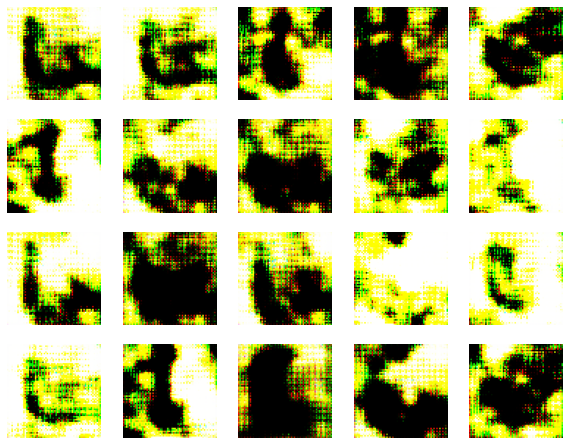

In [93]:
#seed2 = tf.random.normal([BATCH_SIZE, SEED_SIZE])
#generated_images2 = generator(seed2, training = True)

X_fake, y_fake = generate_fake_samples(generator, IMAGE_CHANNELS, BATCH_SIZE)
generated_images2 =0.5 * X_fake + 0.5

fig = pyplot.figure(figsize=(10,10))
for i in range(1,21):
    fig.add_subplot(5,5,i)
    pyplot.imshow(generated_images2[i])
    pyplot.axis('off')

##starting

In [94]:
#noise = tf.random.normal([BATCH_SIZE, SEED_SIZE])
#generated_images = generator(noise, training=False)
X_fake, y_fake = generate_fake_samples(generator, IMAGE_CHANNELS, BATCH_SIZE)

val_img = np.zeros((BATCH_SIZE, 75, 75, 3))
val_img[:, :64, :64, :] = next(iter(training_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices(val_img).shuffle(9000).batch(BATCH_SIZE)

In [95]:
val_gen_img = np.zeros((BATCH_SIZE, 75, 75, 3))
val_gen_img[:, :64, :64, :] = X_fake
val_dataset_gen = tf.data.Dataset.from_tensor_slices(val_gen_img).shuffle(9000).batch(BATCH_SIZE)

In [96]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=val_img.shape[1:], weights="imagenet", pooling='avg')

In [97]:
from tqdm import tqdm
def compute_embeddings(dataloader, count):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)

count = math.ceil(10000/BATCH_SIZE)

# compute embeddings for real images
real_image_embeddings = compute_embeddings(val_dataset, count)

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(val_dataset_gen, count)

real_image_embeddings.shape, generated_image_embeddings.shape

100%|██████████| 157/157 [00:13<00:00, 11.73it/s]


((10048, 2048), (10048, 2048))

In [98]:
from scipy.linalg import sqrtm

def calculate_fid(real_embeddings, generated_embeddings):
    # calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

fid = calculate_fid(real_image_embeddings, generated_image_embeddings)
fid

859.0530670104113